In [32]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

import time
from tqdm import tqdm

In [33]:
structure = 'Crystalline'

In [34]:
mcg = 300

In [35]:
topology = '../ClathrateTPS/gro_files/conf.gro'

In [5]:
def autocorrelation(data, maxlag = None):
    """
    Compute the autocorrelation function (VACF).
    
    Parameters:
        data (numpy.ndarray): Velocity array of shape (n_frames, n_atoms, 3).
    
    Returns:
        numpy.ndarray: Autocorrelation function over time.
    """
        
    n_frames = data.shape[0]

    if maxlag == None or maxlag > n_frames:
        print(f'Setting maxlag to {n_frames}!')
        maxlag = n_frames

    # Compute dot product of data at different time points
    vacf = np.zeros(maxlag)

    print(f'going to maxlag {maxlag}')

    for t in range(maxlag):
        print(f"\r{t}/{maxlag}", end="", flush=True)

        # print(f"#######{t}#######")
        v_t = data[:n_frames - t]
        v_t_dt = data[t:]

        dot_product = np.einsum('ijk,ijk->ij', v_t, v_t_dt)# this sums over last dimension os i this case the coordinates

        #print(dot_product.shape)
        
        particle_mean = np.mean(dot_product, axis = 1)# this means over the atoms+
        
        vacf[t] = np.mean(particle_mean)
        # print(result)
        # print(v_t.shape)

        # dot_product = np.einsum('fij,fij->f', data[:n_frames - t], velocities[t:])
        # print(dot_product)
        # vacf[t] = np.mean(dot_product)

    # Normalize by t=0 value
    vacf /=  vacf[0]
    
    return vacf

In [6]:
def autocorrelation(data, maxlag=None, stride=1):
    """
    Compute the autocorrelation function (VACF) with a stride over the lag.
    
    Parameters:
        data (numpy.ndarray): Velocity array of shape (n_frames, n_atoms, 3).
        maxlag (int, optional): Maximum lag to compute. Defaults to total frames.
        stride (int): Step size between computed lags (must be >=1). Defaults to 1.
    
    Returns:
        numpy.ndarray: Autocorrelation function over time at specified lags.
    """
    n_frames = data.shape[0]
    
    # Set maxlag to n_frames if not specified or too large
    if maxlag is None or maxlag > n_frames:
        print(f'Setting maxlag to {n_frames}!')
        maxlag = n_frames
    
    # Validate stride
    stride = max(1, stride)  # Ensure stride is at least 1
    lags = range(0, maxlag, stride)  # Lags to compute (0, stride, 2*stride, ...)
    n_lags = len(lags)
    vacf = np.zeros(n_lags)
    
    print(f'Computing {n_lags} lags (stride={stride}) up to maxlag {maxlag}')
    
    # Compute autocorrelation only at selected lags
    for idx, t in enumerate(lags):
        print(f"\r{idx + 1}/{n_lags} (lag={t})", end="", flush=True)
        
        # Slice data for current lag
        v_t = data[:n_frames - t]  # Initial frames: [0, n_frames - t - 1]
        v_t_dt = data[t:]          # Shifted frames: [t, n_frames - 1]
        
        # Dot product and averaging
        dot_product = np.einsum('ijk,ijk->ij', v_t, v_t_dt)  # Sum over coordinates
        particle_mean = np.mean(dot_product, axis=1)          # Average over atoms
        vacf[idx] = np.mean(particle_mean)                   # Average over time
    
    print()  # Newline after progress
    vacf /= vacf[0]  # Normalize by t=0 value
    return vacf

In [7]:

def calculate_vacf(vel):
    """
    Computes the velocity autocorrelation function (VACF) for a 3D trajectory.
    
    Args:
        vel: NumPy array of shape (n_frames, n_atoms, 3) containing velocity vectors
    
    Returns:
        vacf: NumPy array of shape (n_frames,) containing the VACF values
    """
    n_frames, n_atoms, _ = vel.shape
    if n_frames < 2:
        return np.zeros(n_frames, dtype=vel.dtype)
    
    n_pad = 2 * n_frames
    padded_vel = np.zeros((n_pad, n_atoms, 3), dtype=vel.dtype)
    padded_vel[:n_frames] = vel
    
    # Real FFT along time axis
    vel_fft = np.fft.rfft(padded_vel, axis=0)
    
    # Power spectrum
    S = np.abs(vel_fft) ** 2
    
    # Inverse FFT to get autocorrelation
    autocorr_unscaled = np.fft.irfft(S, axis=0, n=n_pad)[:n_frames]
    
    # Sum over spatial components
    autocorr_unscaled_total = np.sum(autocorr_unscaled, axis=-1)
    
    # Normalization factors
    norm_factors = (n_frames - np.arange(n_frames)).astype(vel.dtype)
    autocorr_normalized = autocorr_unscaled_total / norm_factors[:, np.newaxis]
    
    # Average over atoms
    return np.mean(autocorr_normalized, axis=1)

## Short timescale

In [8]:
stride = 1
lag_stride = 1
burst = 1    #this number comes from the simulation

end = 1000

In [9]:
file_path = f'/leonardo_scratch/large/userexternal/mhaeupl0/InitialTrajectories/{structure}/cv_{mcg}/N_out_1_N_2e5/trajectory.h5'

In [10]:
with h5py.File(file_path, 'r') as f:
    print(f["coordinates"].shape)

    if end == -1:
        end = f["coordinates"].shape[0]

print(end)

(200001, 13312, 3)
1000


In [11]:
with h5py.File(file_path, "r") as f:
    total_frames = f["coordinates"].shape[0]
    n_atoms = f["coordinates"].shape[1]
    
    # Calculate indices you're going to load
    indices = np.arange(0, end, stride)
    n_frames = len(indices)

    # Preallocate arrays
    coordinates = np.empty((n_frames, n_atoms, 3), dtype=np.float32)
    velocities = np.empty((n_frames, n_atoms, 3), dtype=np.float32)

    for i, idx in enumerate(tqdm(indices, desc="Loading trajectory")):
        coordinates[i] = f["coordinates"][idx]
        velocities[i] = f["velocities"][idx]

Loading trajectory: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.16it/s]


In [12]:
vel_one_step = velocities[:end]
cor_one_step = coordinates[:end]

In [13]:
acf_vel = autocorrelation(vel_one_step, maxlag = end//2, stride = lag_stride)
acf_pos = autocorrelation(cor_one_step, maxlag = end//2, stride = lag_stride)

Computing 500 lags (stride=1) up to maxlag 500
500/500 (lag=499)
Computing 500 lags (stride=1) up to maxlag 500
500/500 (lag=499)


In [14]:
np.save(f'ACF_results/5e2_{structure}_mcg_{mcg}/acf_vel', acf_vel)
np.save(f'ACF_results/5e2_{structure}_mcg_{mcg}/acf_pos', acf_pos)

#np.save(f'ACF_results/2e5_{structure}_mcg_{mcg}/acf_vel', acf_vel)
#np.save(f'ACF_results/2e5_{structure}_mcg_{mcg}/acf_pos', acf_pos)

In [36]:
# Colormaps
import matplotlib.colors as mcolors 
from cmap import Colormap

cm1_name = 'crameri:lipari'


cm = Colormap(f'{cm1_name}')
mpl_cm = cm.to_mpl()#.reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 100))
#truncate_point = 0.1
#truncated_colors = cmap_colors[int(256 * truncate_point):]
#cmap1 = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

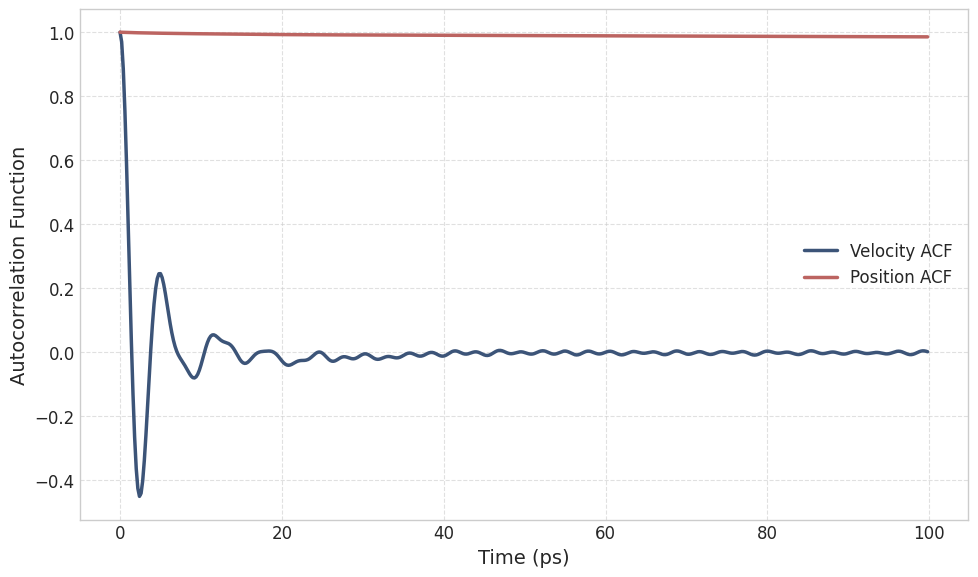

In [37]:
idx2step = burst * stride * lag_stride
step2ps = 2e-3
time = np.arange(acf_pos.shape[0]) * idx2step * step2ps

# Plot settings
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')  # cleaner background

# Plot lines
plt.plot(time, acf_vel, color=cmap_colors[20], linewidth=2.5, label='Velocity ACF')
plt.plot(time, acf_pos, color=cmap_colors[55], linewidth=2.5, linestyle='-', label='Position ACF')

# Vertical reference line
#plt.axvline(200, color='grey', linestyle='--', linewidth=1.5, label='Saving Interval')

# Axis limits
#plt.xlim(-10, 0.1e7)

# Labels and title
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('Autocorrelation Function', fontsize=14)
# plt.title('Velocity and Position Autocorrelation Functions', fontsize=16)  # optional

# Legend and grid
plt.legend(loc='center right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Tick formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Layout and show
plt.tight_layout()
plt.savefig('../figures/VACF/AutocorrelationFunction_short_mcg_{mcg}_{structure}')
plt.show()

## From Loaded

In [38]:
acf_vel_crystalline_10 = np.load('ACF_results/2e5_Crystalline_mcg_10/acf_vel.npy')
acf_pos_crystalline_10 = np.load('ACF_results/2e5_Crystalline_mcg_10/acf_pos.npy')
acf_vel_crystalline_300 = np.load('ACF_results/2e5_Crystalline_mcg_300/acf_vel.npy')
acf_pos_crystalline_300 = np.load('ACF_results/2e5_Crystalline_mcg_300/acf_pos.npy')
acf_vel_amorphous_300 = np.load('ACF_results/2e5_Amorphous_mcg_300/acf_vel.npy')
acf_pos_amorphous_300 = np.load('ACF_results/2e5_Amorphous_mcg_300/acf_pos.npy')

acf_vel_crystalline_10_5e2 = np.load('ACF_results/5e2_Crystalline_mcg_10/acf_vel.npy')
acf_pos_crystalline_10_5e2 = np.load('ACF_results/5e2_Crystalline_mcg_10/acf_pos.npy')
acf_vel_crystalline_300_5e2 = np.load('ACF_results/5e2_Crystalline_mcg_300/acf_vel.npy')
acf_pos_crystalline_300_5e2 = np.load('ACF_results/5e2_Crystalline_mcg_300/acf_pos.npy')
acf_vel_amorphous_300_5e2 = np.load('ACF_results/5e2_Amorphous_mcg_300/acf_vel.npy')
acf_pos_amorphous_300_5e2 = np.load('ACF_results/5e2_Amorphous_mcg_300/acf_pos.npy')


In [42]:
plt.rcParams.update({
    'axes.grid': True
})

In [52]:
# Colormaps
import matplotlib.colors as mcolors 
from cmap import Colormap

cm1_name = 'cmasher:guppy'


cm = Colormap(f'{cm1_name}')
mpl_cm = cm.to_mpl()#.reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 100))
#truncate_point = 0.1

#truncated_colors = cmap_colors[int(256 * truncate_point):]
#cmap1 = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

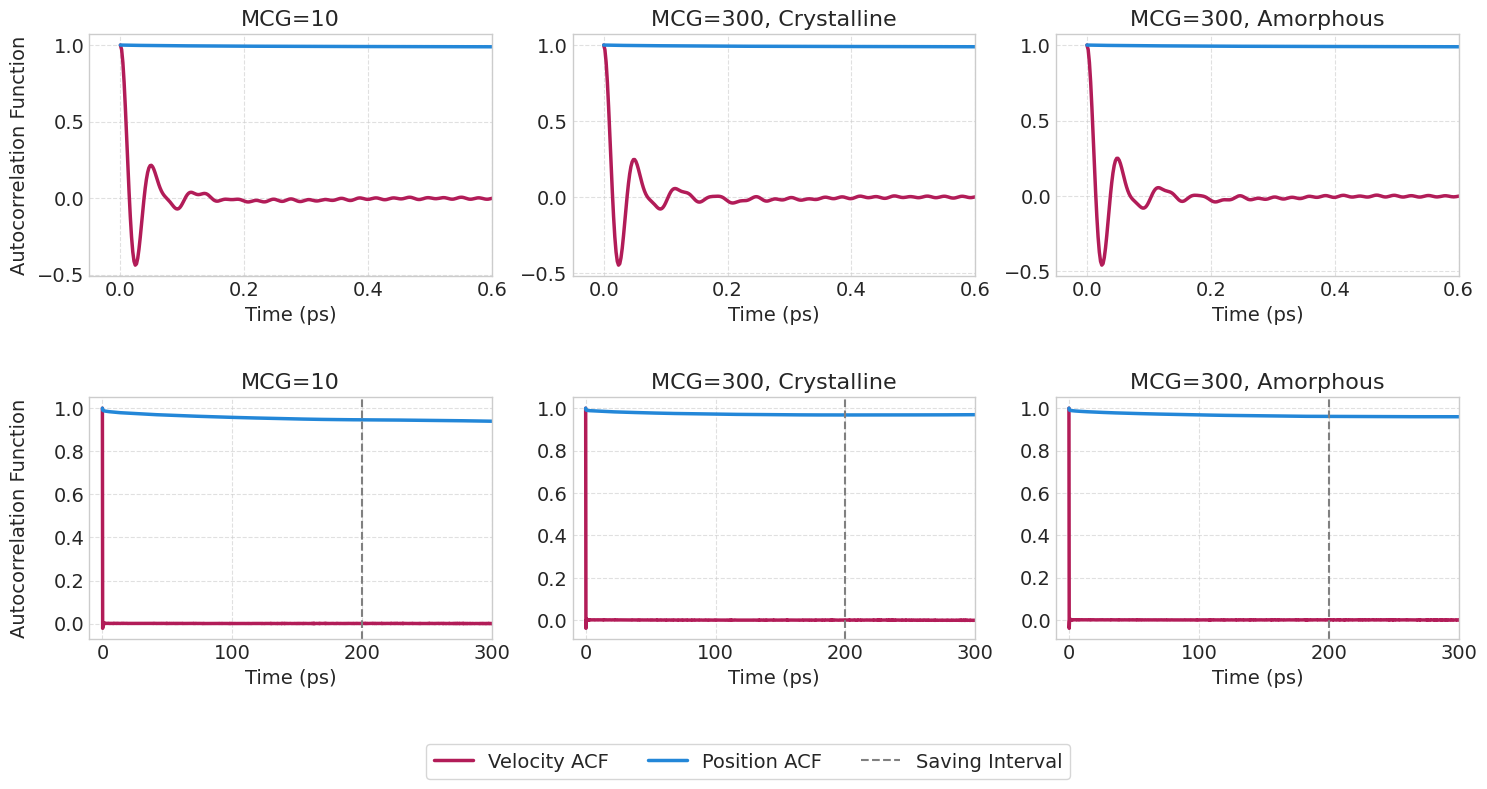

In [55]:
# Create figure with larger default font sizes
plt.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.titlesize': 16,      # Title font size
    'axes.labelsize': 14,      # Axis label font size
    'xtick.labelsize': 14,     # X-tick label size
    'ytick.labelsize': 14,     # Y-tick label size
    'legend.fontsize': 14      # Legend font size
})

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.style.use('seaborn-v0_8-whitegrid')
step2ps = 2e-3  # Global conversion factor

# ====================
# FIRST ROW (5e2 data) - NOW ON TOP
# ====================
burst = 1
stride = 1
lag_stride = 1
idx2step = burst * stride * lag_stride

# Cases for 5e2 data (now first row)
row1_cases = [
    {'structure': '', 'mcg': 10, 'prefix': '5e2', 
     'acf_vel': acf_vel_crystalline_10_5e2, 'acf_pos': acf_pos_crystalline_10_5e2},
    {'structure': ', Crystalline', 'mcg': 300, 'prefix': '5e2', 
     'acf_vel': acf_vel_crystalline_300_5e2, 'acf_pos': acf_pos_crystalline_300_5e2},
    {'structure': ', Amorphous', 'mcg': 300, 'prefix': '5e2', 
     'acf_vel': acf_vel_amorphous_300_5e2, 'acf_pos': acf_pos_amorphous_300_5e2}
]

# Plot first row (5e2 data)
for col in range(3):
    ax = axes[0, col]
    case = row1_cases[col]
    time = np.arange(len(case['acf_pos'])) * idx2step * step2ps
    
    ax.plot(time, case['acf_vel'], color=cmap_colors[30], linewidth=2.5)
    ax.plot(time, case['acf_pos'], color=cmap_colors[80], linewidth=2.5)
    ax.axvline(200, color='grey', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(-0.05, 0.6)
    ax.set_title(f'MCG={case["mcg"]}{case["structure"]}', fontsize=16)
    ax.set_xlabel('Time (ps)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=14)
    
    # Add y-label to first column
    if col == 0:
        ax.set_ylabel('Autocorrelation Function', fontsize=14)
        ax.yaxis.set_label_coords(-0.15, 0.5)

# ====================
# SECOND ROW (2e5 data) - NOW ON BOTTOM
# ====================
burst = 1
stride = 100
lag_stride = 1
idx2step = burst * stride * lag_stride

# Cases for 2e5 data (now second row)
row2_cases = [
    {'structure': '', 'mcg': 10, 'prefix': '2e5', 
     'acf_vel': acf_vel_crystalline_10, 'acf_pos': acf_pos_crystalline_10},
    {'structure': ', Crystalline', 'mcg': 300, 'prefix': '2e5', 
     'acf_vel': acf_vel_crystalline_300, 'acf_pos': acf_pos_crystalline_300},
    {'structure': ', Amorphous', 'mcg': 300, 'prefix': '2e5', 
     'acf_vel': acf_vel_amorphous_300, 'acf_pos': acf_pos_amorphous_300}
]

# Plot second row (2e5 data)
for col in range(3):
    ax = axes[1, col]
    case = row2_cases[col]
    time = np.arange(len(case['acf_pos'])) * idx2step * step2ps
    
    ax.plot(time, case['acf_vel'], color=cmap_colors[30], linewidth=2.5)
    ax.plot(time, case['acf_pos'], color=cmap_colors[80], linewidth=2.5)
    ax.axvline(200, color='grey', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(-10, 300)
    ax.set_xlabel('Time (ps)', fontsize=14)
    ax.set_title(f'MCG={case["mcg"]}{case["structure"]}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=14)
    
    # Add y-label to first column
    if col == 0:
        ax.set_ylabel('Autocorrelation Function', fontsize=14)
        ax.yaxis.set_label_coords(-0.15, 0.5)

# Add global legend with larger font
fig.legend(
    handles=[
        plt.Line2D([0], [0], color=cmap_colors[30], lw=2.5, label='Velocity ACF'),
        plt.Line2D([0], [0], color=cmap_colors[80], lw=2.5, label='Position ACF'),
        plt.Line2D([0], [0], color='grey', linestyle='--', lw=1.5, label='Saving Interval')
    ],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    fontsize=14,
    frameon=True
)

# Adjust layout with more space for legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.5, wspace=0.2)

plt.savefig('../figures/VACF/AutocorrelationFunctions_comparison_2rows.png', dpi=300, bbox_inches='tight')
plt.show()

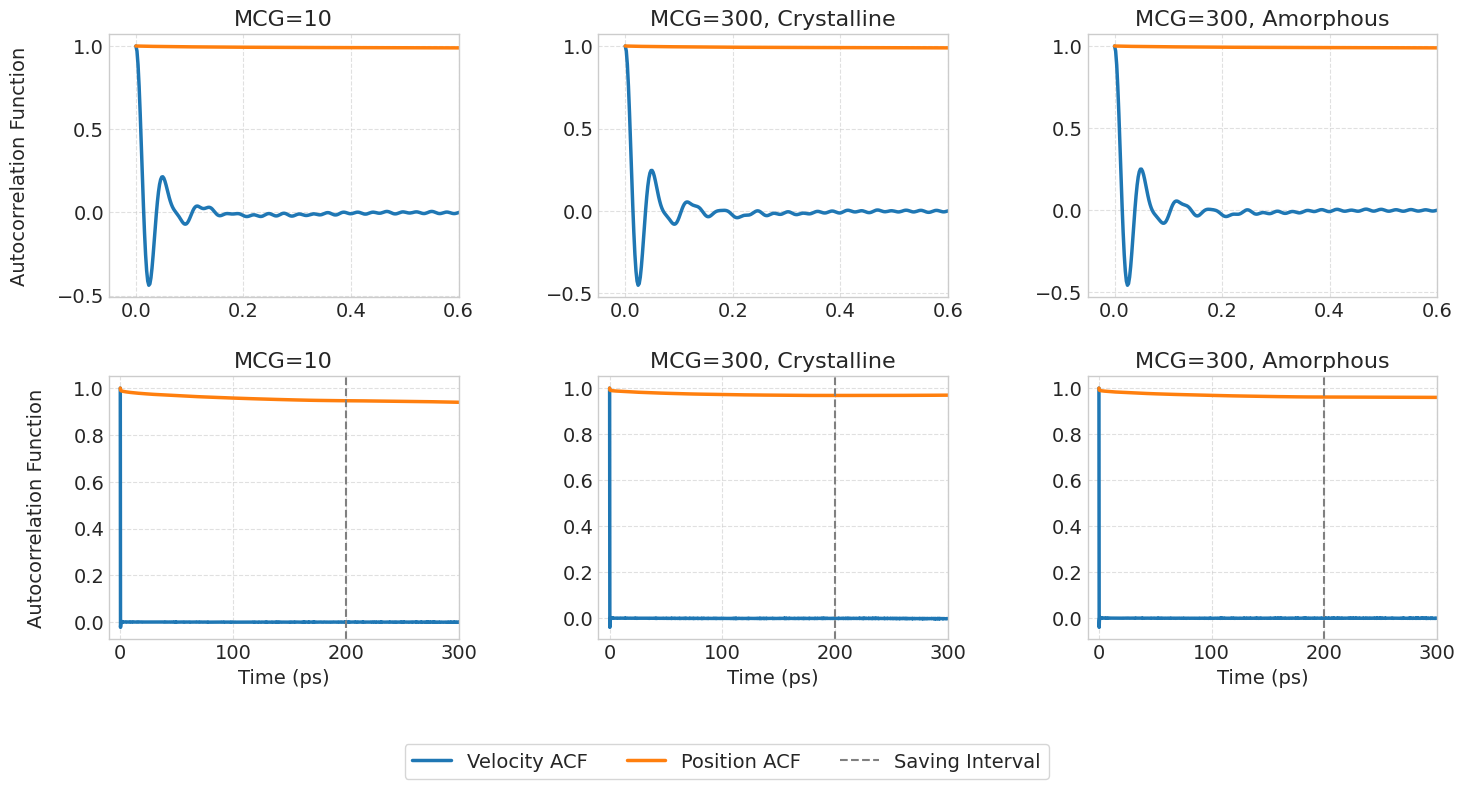

In [28]:
# Create figure with larger default font sizes
plt.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.titlesize': 16,      # Title font size
    'axes.labelsize': 14,      # Axis label font size
    'xtick.labelsize': 14,     # X-tick label size
    'ytick.labelsize': 14,     # Y-tick label size
    'legend.fontsize': 14      # Legend font size
})

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.style.use('seaborn-v0_8-whitegrid')
step2ps = 2e-3  # Global conversion factor

# ====================
# FIRST ROW (5e2 data)
# ====================
burst = 1
stride = 1
lag_stride = 1
idx2step = burst * stride * lag_stride

# Cases for 5e2 data
row1_cases = [
    {'structure': '', 'mcg': 10, 'prefix': '5e2', 
     'acf_vel': acf_vel_crystalline_10_5e2, 'acf_pos': acf_pos_crystalline_10_5e2},
    {'structure': ', Crystalline', 'mcg': 300, 'prefix': '5e2', 
     'acf_vel': acf_vel_crystalline_300_5e2, 'acf_pos': acf_pos_crystalline_300_5e2},
    {'structure': ', Amorphous', 'mcg': 300, 'prefix': '5e2', 
     'acf_vel': acf_vel_amorphous_300_5e2, 'acf_pos': acf_pos_amorphous_300_5e2}
]

# Plot first row (5e2 data)
for col in range(3):
    ax = axes[0, col]
    case = row1_cases[col]
    time = np.arange(len(case['acf_pos'])) * idx2step * step2ps
    
    ax.plot(time, case['acf_vel'], color='tab:blue', linewidth=2.5)
    ax.plot(time, case['acf_pos'], color='tab:orange', linewidth=2.5)
    ax.axvline(200, color='grey', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(-0.05, 0.6)
    ax.set_title(f'MCG={case["mcg"]}{case["structure"]}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=14)
    
    # Add y-label to first column with increased padding
    if col == 0:
        ax.set_ylabel('Autocorrelation Function', fontsize=14, labelpad=20)  # Increased padding

# ====================
# SECOND ROW (2e5 data)
# ====================
burst = 1
stride = 100
lag_stride = 1
idx2step = burst * stride * lag_stride

# Cases for 2e5 data
row2_cases = [
    {'structure': '', 'mcg': 10, 'prefix': '2e5', 
     'acf_vel': acf_vel_crystalline_10, 'acf_pos': acf_pos_crystalline_10},
    {'structure': ', Crystalline', 'mcg': 300, 'prefix': '2e5', 
     'acf_vel': acf_vel_crystalline_300, 'acf_pos': acf_pos_crystalline_300},
    {'structure': ', Amorphous', 'mcg': 300, 'prefix': '2e5', 
     'acf_vel': acf_vel_amorphous_300, 'acf_pos': acf_pos_amorphous_300}
]

# Plot second row (2e5 data)
for col in range(3):
    ax = axes[1, col]
    case = row2_cases[col]
    time = np.arange(len(case['acf_pos'])) * idx2step * step2ps
    
    ax.plot(time, case['acf_vel'], color='tab:blue', linewidth=2.5)
    ax.plot(time, case['acf_pos'], color='tab:orange', linewidth=2.5)
    ax.axvline(200, color='grey', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(-10, 300)
    ax.set_xlabel('Time (ps)', fontsize=14)
    ax.set_title(f'MCG={case["mcg"]}{case["structure"]}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=14)
    
    # Add y-label to first column with increased padding
    if col == 0:
        ax.set_ylabel('Autocorrelation Function', fontsize=14, labelpad=20)  # Increased padding

# Add global legend with larger font
fig.legend(
    handles=[
        plt.Line2D([0], [0], color='tab:blue', lw=2.5, label='Velocity ACF'),
        plt.Line2D([0], [0], color='tab:orange', lw=2.5, label='Position ACF'),
        plt.Line2D([0], [0], color='grey', linestyle='--', lw=1.5, label='Saving Interval')
    ],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    fontsize=14,
    frameon=True
)

# Adjust layout with more space for legend and y-labels
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.4)  # Increased wspace for y-label clearance
plt.savefig('../figures/VACF/AutocorrelationFunctions_comparison_2rows.png', dpi=300, bbox_inches='tight')
plt.show()

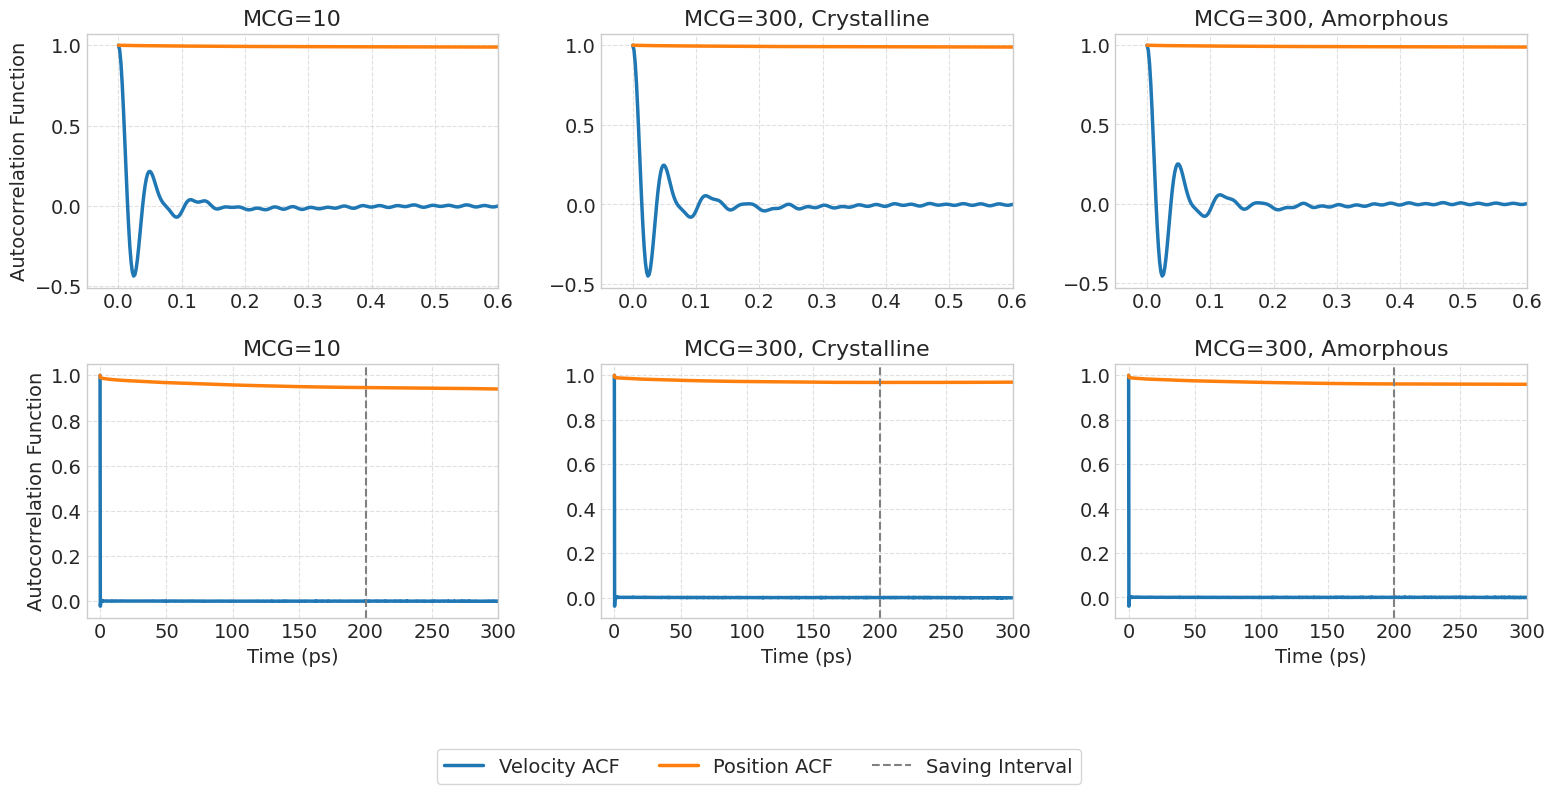

In [29]:
# Create figure with larger default font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Increase figure width and left margin
fig, axes = plt.subplots(2, 3, figsize=(16, 8), gridspec_kw={'left': 0.08, 'right': 0.98})
plt.style.use('seaborn-v0_8-whitegrid')
step2ps = 2e-3

# ====================
# FIRST ROW (5e2 data)
# ====================
burst = 1
stride = 1
lag_stride = 1
idx2step = burst * stride * lag_stride

row1_cases = [
    {'structure': '', 'mcg': 10, 'prefix': '5e2', 
     'acf_vel': acf_vel_crystalline_10_5e2, 'acf_pos': acf_pos_crystalline_10_5e2},
    {'structure': ', Crystalline', 'mcg': 300, 'prefix': '5e2', 
     'acf_vel': acf_vel_crystalline_300_5e2, 'acf_pos': acf_pos_crystalline_300_5e2},
    {'structure': ', Amorphous', 'mcg': 300, 'prefix': '5e2', 
     'acf_vel': acf_vel_amorphous_300_5e2, 'acf_pos': acf_pos_amorphous_300_5e2}
]

for col in range(3):
    ax = axes[0, col]
    case = row1_cases[col]
    time = np.arange(len(case['acf_pos'])) * idx2step * step2ps
    
    ax.plot(time, case['acf_vel'], color='tab:blue', linewidth=2.5)
    ax.plot(time, case['acf_pos'], color='tab:orange', linewidth=2.5)
    ax.axvline(200, color='grey', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(-0.05, 0.6)
    ax.set_title(f'MCG={case["mcg"]}{case["structure"]}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=14)
    
    if col == 0:
        ax.set_ylabel('Autocorrelation Function', fontsize=14)

# ====================
# SECOND ROW (2e5 data)
# ====================
burst = 1
stride = 100
lag_stride = 1
idx2step = burst * stride * lag_stride

row2_cases = [
    {'structure': '', 'mcg': 10, 'prefix': '2e5', 
     'acf_vel': acf_vel_crystalline_10, 'acf_pos': acf_pos_crystalline_10},
    {'structure': ', Crystalline', 'mcg': 300, 'prefix': '2e5', 
     'acf_vel': acf_vel_crystalline_300, 'acf_pos': acf_pos_crystalline_300},
    {'structure': ', Amorphous', 'mcg': 300, 'prefix': '2e5', 
     'acf_vel': acf_vel_amorphous_300, 'acf_pos': acf_pos_amorphous_300}
]

for col in range(3):
    ax = axes[1, col]
    case = row2_cases[col]
    time = np.arange(len(case['acf_pos'])) * idx2step * step2ps
    
    ax.plot(time, case['acf_vel'], color='tab:blue', linewidth=2.5)
    ax.plot(time, case['acf_pos'], color='tab:orange', linewidth=2.5)
    ax.axvline(200, color='grey', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(-10, 300)
    ax.set_xlabel('Time (ps)', fontsize=14)
    ax.set_title(f'MCG={case["mcg"]}{case["structure"]}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=14)
    
    if col == 0:
        ax.set_ylabel('Autocorrelation Function', fontsize=14)

# Add global legend with adjusted position
fig.legend(
    handles=[
        plt.Line2D([0], [0], color='tab:blue', lw=2.5, label='Velocity ACF'),
        plt.Line2D([0], [0], color='tab:orange', lw=2.5, label='Position ACF'),
        plt.Line2D([0], [0], color='grey', linestyle='--', lw=1.5, label='Saving Interval')
    ],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.07),  # Lowered legend position
    ncol=3,
    fontsize=14,
    frameon=True
)

# Adjust layout with more space at bottom for legend
plt.subplots_adjust(bottom=0.15, hspace=0.3, wspace=0.25)
plt.savefig('../figures/VACF/AutocorrelationFunctions_comparison_2rows.png', dpi=300, bbox_inches='tight')
plt.show()